# Marine traffic API

In [1]:
import pandas as pd
from marinetrafficapi import MarineTrafficApi
import json
import geopandas as gpd

/Users/stiles/.pyenv/versions/3.9.9/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
historical_key = '662aafc8dca2566936d60a4bd09d015134c7179e'
single_vessel_key = 'de4f4cd8e8aec06e897374f9ff2f60029b5e8340'
vessel_particulars = '82f7375a3d5289bfb90f5695505fb95214cfed01'

In [3]:
api = MarineTrafficApi(api_key=vessel_particulars)

In [4]:
with open('data/raw/ships_2022_latest.json') as f:
    data_file = json.load(f)

In [5]:
src = pd.DataFrame(data_file['data']['rows'])

In [6]:
src.columns = src.columns.str.lower()

In [7]:
src.destination = src.destination.str.title()
src.shipname = src.shipname.str.title()

In [8]:
src.flag.value_counts()

KY    19
BM     4
RU     3
GB     2
MH     2
VC     2
CK     1
MT     1
VG     1
Name: flag, dtype: int64

In [9]:
flags = {
'KY':'Cayman Islands',
'BM':'Bermuda',
'RU':'Russia',
'GB':'United Kingdom',
'MH':'Marshall Islands',
'VC':'St Vincent Grenadines',
'CK':'Cook Island',
'MT':'Malta',
'VG':'British Virgin Islands'
}

In [10]:
src['flag_country'] = src['flag'].map(flags)

In [11]:
src[['length', 'width', 'course', 'heading', 'elapsed']] = src[['length', 'width', 'course', 'heading', 'elapsed']].astype(float)

In [12]:
src.head()

,lat,lon,speed,course,heading,elapsed,destination,flag,length,shipname,shiptype,ship_id,width,l_fore,w_left,dwt,gt_shiptype,rot,flag_country
0,36.27028,-2.948983,92,8.0,82.0,2300.0,Cruising,BM,162.50,Eclipse,9,371584,22.40,82,11,1480,55,NaN,Bermuda
1,45.63432,13.77455,0,3.0,33.0,24475.0,Trieste,GB,142.81,Sailing Yacht A,6,3598603,25.00,80,15,1458,203,NaN,United Kingdom
2,53.5426,9.964017,0,175.0,47.0,119785.0,Hamburg,KY,156.00,Dilbar,9,3786839,24.00,58,12,1230,55,0,Cayman Islands
3,4.421157,73.28638,172,359.0,1.0,6081.0,Mvmle,GB,118.00,A,9,371455,18.00,62,10,1126,55,-1,United Kingdom
4,18.02214,-63.10355,1,98.0,99.0,3.0,Bqeux,BM,108.30,Le Grand Bleu,9,371059,20.23,19,10,1248,55,0,Bermuda


In [13]:
src.length.mean().round(2)

93.7

In [14]:
gdf = gpd.GeoDataFrame(
    src, geometry=gpd.points_from_xy(src.lon, src.lat)).reset_index(drop=True)

In [15]:
gdf = gdf.set_crs("EPSG:4326")

#### EEZ country

In [16]:
eez = gpd.read_file('/Users/stiles/data/gis/marine_regions/World_EEZ_v11_20191118/eez_v11_simple.json')

In [17]:
eez.columns = eez.columns.str.lower().str.replace('1', "", regex=False)

In [18]:
# eez.geometry = eez.geometry.to_crs('epsg:3395')

<AxesSubplot:>

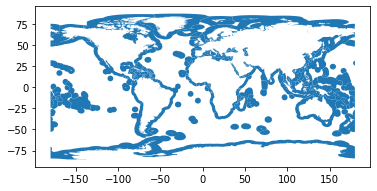

In [19]:
eez.plot()

In [20]:
eez_slim = eez[['geometry', 'sovereign']]

In [21]:
# eez_slim.geometry_buffer = eez_slim.geometry.buffer(0.2)

In [22]:
gdf_eez = gdf.sjoin(eez_slim, how="left", predicate="within")

In [23]:
gdf_eez.sovereign = gdf_eez.sovereign.fillna('Other')

In [24]:
gdf_eez.sovereign.value_counts()

Other                               12
Italy                                4
Spain                                3
Maldives                             3
Seychelles                           3
United Arab Emirates                 2
Montenegro                           2
Netherlands                          1
Germany                              1
Russia                               1
Costa Rica                           1
Saint Vincent and the Grenadines     1
Turkey                               1
Name: sovereign, dtype: int64

In [25]:
gdf_eez.head()

,lat,lon,speed,course,heading,elapsed,destination,flag,length,shipname,...,width,l_fore,w_left,dwt,gt_shiptype,rot,flag_country,geometry,index_right,sovereign
0,36.27028,-2.948983,92,8.0,82.0,2300.0,Cruising,BM,162.50,Eclipse,...,22.40,82,11,1480,55,NaN,Bermuda,POINT (-2.94898 36.27028),276.0,Spain
1,45.63432,13.77455,0,3.0,33.0,24475.0,Trieste,GB,142.81,Sailing Yacht A,...,25.00,80,15,1458,203,NaN,United Kingdom,POINT (13.77455 45.63432),NaN,Other
2,53.5426,9.964017,0,175.0,47.0,119785.0,Hamburg,KY,156.00,Dilbar,...,24.00,58,12,1230,55,0,Cayman Islands,POINT (9.96402 53.54260),NaN,Other
3,4.421157,73.28638,172,359.0,1.0,6081.0,Mvmle,GB,118.00,A,...,18.00,62,10,1126,55,-1,United Kingdom,POINT (73.28638 4.42116),258.0,Maldives
4,18.02214,-63.10355,1,98.0,99.0,3.0,Bqeux,BM,108.30,Le Grand Bleu,...,20.23,19,10,1248,55,0,Bermuda,POINT (-63.10355 18.02214),100.0,Netherlands


---

#### Marine data exports

In [26]:
mde_df = pd.read_csv('data/raw/MarineTraffic_VesselExport_2022-03-12.csv')

In [27]:
mde_df.columns = mde_df.columns.str.lower().str.replace(' ',"_", regex=False)

In [28]:
mde_df.head()

,flag,vessel_name,destination_port,reported_eta,reported_destination,calculated_eta,current_port,imo,vessel_type_-_generic,time_of_latest_position,latitude,longitude,my_fleets
0,Bermuda,ECLIPSE,NaN,2022-03-03 13:00:00,CRUISING,NaN,NaN,1009613,Pleasure Craft,2022-03-13 01:51:49,36.270280,-2.948983,-
1,United Kingdom,SAILING YACHT A,TRIESTE,2022-01-05 10:10:00,TRIESTE,NaN,TRIESTE,1012141,Passenger,2022-02-25 16:16:35,45.634320,13.774550,-
2,Cayman Is,DILBAR,HAMBURG,2021-10-29 09:00:00,HAMBURG,NaN,HAMBURG,9661792,Pleasure Craft,2021-12-21 11:46:24,53.542600,9.964017,-
3,United Kingdom,A,MALE,2021-12-02 08:00:00,MVMLE,NaN,NaN,1009340,Pleasure Craft,2022-03-10 10:50:53,4.421157,73.286380,-
4,Bermuda,LE GRAND BLEU,NaN,2022-05-02 14:00:00,SXM SIMPSON BAY,NaN,PHILIPSBURG ANCH,1006829,Pleasure Craft,2022-03-14 15:38:52,18.022090,-63.103520,-


In [29]:
mde_df['vessel_name'] = mde_df['vessel_name'].str.title()

In [30]:
mde_df_slim = mde_df[['vessel_name', 'current_port', 'time_of_latest_position']].copy()

In [31]:
mde_df_slim['last_date_display'] = pd.to_datetime(mde_df_slim['time_of_latest_position']).dt.strftime('%b. %-d, %Y')

In [32]:
mde_df_slim['last_date'] = pd.to_datetime(mde_df_slim['time_of_latest_position'])

In [33]:
mde_df_slim.sort_values('last_date').head(5)

,vessel_name,current_port,time_of_latest_position,last_date_display,last_date
21,Amore Vero,LA CIOTAT,2013-07-14 16:35:00,"Jul. 14, 2013",2013-07-14 16:35:00
23,Lady M,IMPERIA,2016-08-25 16:17:33,"Aug. 25, 2016",2016-08-25 16:17:33
11,Palladium,BARCELONA,2020-06-16 12:12:48,"Jun. 16, 2020",2020-06-16 12:12:48
34,Lena,SANREMO,2021-09-24 11:16:16,"Sep. 24, 2021",2021-09-24 11:16:16
27,Royal Romance,RIJEKA,2021-10-08 06:33:20,"Oct. 8, 2021",2021-10-08 06:33:20


In [34]:
src.head()

,lat,lon,speed,course,heading,elapsed,destination,flag,length,shipname,shiptype,ship_id,width,l_fore,w_left,dwt,gt_shiptype,rot,flag_country,geometry
0,36.27028,-2.948983,92,8.0,82.0,2300.0,Cruising,BM,162.50,Eclipse,9,371584,22.40,82,11,1480,55,NaN,Bermuda,POINT (-2.94898 36.27028)
1,45.63432,13.77455,0,3.0,33.0,24475.0,Trieste,GB,142.81,Sailing Yacht A,6,3598603,25.00,80,15,1458,203,NaN,United Kingdom,POINT (13.77455 45.63432)
2,53.5426,9.964017,0,175.0,47.0,119785.0,Hamburg,KY,156.00,Dilbar,9,3786839,24.00,58,12,1230,55,0,Cayman Islands,POINT (9.96402 53.54260)
3,4.421157,73.28638,172,359.0,1.0,6081.0,Mvmle,GB,118.00,A,9,371455,18.00,62,10,1126,55,-1,United Kingdom,POINT (73.28638 4.42116)
4,18.02214,-63.10355,1,98.0,99.0,3.0,Bqeux,BM,108.30,Le Grand Bleu,9,371059,20.23,19,10,1248,55,0,Bermuda,POINT (-63.10355 18.02214)


In [35]:
src_merge = pd.merge(src, mde_df_slim, left_on='shipname', right_on='vessel_name')

In [36]:
len(src_merge)

35

In [37]:
src_merge.loc[src_merge['vessel_name'] == 'Amore Vero', 'last_date'] = '2022-03-01'

In [38]:
src_merge

,lat,lon,speed,course,heading,elapsed,destination,flag,length,shipname,...,dwt,gt_shiptype,rot,flag_country,geometry,vessel_name,current_port,time_of_latest_position,last_date_display,last_date
0,36.27028,-2.948983,92,8.0,82.0,2300.0,Cruising,BM,162.50,Eclipse,...,1480,55,NaN,Bermuda,POINT (-2.94898 36.27028),Eclipse,NaN,2022-03-13 01:51:49,"Mar. 13, 2022",2022-03-13 01:51:49
1,45.63432,13.77455,0,3.0,33.0,24475.0,Trieste,GB,142.81,Sailing Yacht A,...,1458,203,NaN,United Kingdom,POINT (13.77455 45.63432),Sailing Yacht A,TRIESTE,2022-02-25 16:16:35,"Feb. 25, 2022",2022-02-25 16:16:35
2,53.5426,9.964017,0,175.0,47.0,119785.0,Hamburg,KY,156.00,Dilbar,...,1230,55,0,Cayman Islands,POINT (9.96402 53.54260),Dilbar,HAMBURG,2021-12-21 11:46:24,"Dec. 21, 2021",2021-12-21 11:46:24
3,4.421157,73.28638,172,359.0,1.0,6081.0,Mvmle,GB,118.00,A,...,1126,55,-1,United Kingdom,POINT (73.28638 4.42116),A,NaN,2022-03-10 10:50:53,"Mar. 10, 2022",2022-03-10 10:50:53
4,18.02214,-63.10355,1,98.0,99.0,3.0,Bqeux,BM,108.30,Le Grand Bleu,...,1248,55,0,Bermuda,POINT (-63.10355 18.02214),Le Grand Bleu,PHILIPSBURG ANCH,2022-03-14 15:38:52,"Mar. 14, 2022",2022-03-14 15:38:52
5,25.26916,55.27261,64,352.0,349.0,12002.0,Rashid,KY,99.00,Madame Gu,...,549,55,0,Cayman Islands,POINT (55.27261 25.26916),Madame Gu,DUBAI,2022-03-06 08:09:10,"Mar. 6, 2022",2022-03-06 08:09:10
6,53.54255,9.956523,0,329.0,255.0,20611.0,Shiffting Berth,MH,114.00,Luna,...,1290,55,0,Marshall Islands,POINT (9.95652 53.54255),Luna,HAMBURG,2022-02-28 08:40:55,"Feb. 28, 2022",2022-02-28 08:40:55
7,25.26196,55.27411,0,NaN,358.0,3.0,Ae Pra,KY,88.39,Nirvana,...,NaN,55,NaN,Cayman Islands,POINT (55.27411 25.26196),Nirvana,DUBAI,2022-03-14 15:38:56,"Mar. 14, 2022",2022-03-14 15:38:56
8,54.68985,20.37294,88,89.0,93.0,47955.0,New York,RU,80.30,Graceful,...,540,55,3,Russia,POINT (20.37294 54.68985),Graceful,NaN,2022-02-09 08:56:59,"Feb. 9, 2022",2022-02-09 08:56:59
9,-4.648077,55.58191,61,89.0,85.0,1401.0,Silhouette,KY,107.40,Andromeda,...,1000,55,2,Cayman Islands,POINT (55.58191 -4.64808),Andromeda,NaN,2022-03-13 16:50:43,"Mar. 13, 2022",2022-03-13 16:50:43


---

#### Grid yacht list

In [39]:
yacht_ref = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQbuMsq9hYBJIHzjTOQTuhutfl11pSyvcYeSkFB8oxZ9h0glCjpf8_DEseVHkckWz1_DB7uo8s74MnN/pub?gid=1474724732&single=true&output=csv', dtype={'mmsi':str, 'id':str})

In [40]:
yacht_ref.head()

,id,mmsi,name,url,value,value_source,Oligarch,Source:,more_notes,Vessel Sanctioned?,owner_us_sanction,seized,Owner sanctioned by Canada,Sanctions source
0,371455,232039748,A,https://www.marinetraffic.com/en/ais/details/s...,204000000,Forbes,Andrey Melnichenko,https://www.forbes.com/sites/giacomotognini/20...,NaN,NaN,True,NaN,True,https://www.opensanctions.org/entities/ca-sema...
1,3515668,319879000,ANDROMEDA,https://www.marinetraffic.com/en/ais/details/s...,250000000,https://www.superyachtfan.com/yacht/andromeda/...,Yuri Milner,https://www.forbes.com/pictures/5cd6f7af169cc6...,NaN,NaN,False,NaN,NaN,NaN
2,5615797,319138100,ANNA,https://www.marinetraffic.com/en/ais/details/s...,250000000,https://nypost.com/2022/03/05/russian-oligarch...,Dmitry Rybolovlev,https://www.forbes.com/sites/giacomotognini/20...,NaN,NaN,False,NaN,NaN,NaN
3,4890250,319112700,AURORA,https://www.marinetraffic.com/en/ais/details/s...,110000000,Forbes,Andrei Molchanov,https://www.forbes.com/sites/giacomotognini/20...,NaN,NaN,False,NaN,NaN,NaN
4,385196,319143000,CLIO,https://www.marinetraffic.com/en/ais/details/s...,58000000,Forbes,Oleg Deripaska,https://www.forbes.com/sites/giacomotognini/20...,NaN,NaN,True,NaN,NaN,NaN


In [41]:
yacht_ref.columns = yacht_ref.columns.str.lower()

In [42]:
mmsi_list = yacht_ref.mmsi.to_list()

In [43]:
mmsi_list[0]

'232039748'

----

#### Get vessel particulars from Marine Traffic API

In [44]:
# vessel_particulars = api.vessel_particulars(mmsi=232039748)

#### Loop and snag vessel info

In [45]:
# particular_data = []

# for m in mmsi_list:
#     yacht_info = api.vessel_particulars(mmsi=m)
#     try:
#         particular_data.append(yacht_info.formatted_data[0])
#     except:
#         continue

#### Put the objects in a dataframe

In [46]:
# part_df = pd.DataFrame(particular_data)

In [47]:
# part_df.columns = part_df.columns.str.lower()

#### If not pulling from the API, import last call

In [48]:
part_df = pd.read_csv('data/processed/vessel_particulars_API.csv', dtype={'mmsi':str, 'imo':str, 'build':str, 'IMO':str})
part_df.columns = part_df.columns.str.lower()

In [49]:
part_df.dtypes

mmsi                    object
imo                     object
name                    object
place_of_build          object
build                   object
breadth_extreme        float64
summer_dwt             float64
displacement_summer    float64
callsign                object
flag                    object
draught                float64
length_overall         float64
fuel_consumption       float64
speed_max              float64
speed_service          float64
liquid_oil             float64
owner                   object
manager                 object
manager_owner           object
vessel_type             object
dtype: object

----

#### Merge with reference list to add sanctions

In [50]:
grid_api_merge = pd.merge(part_df, yacht_ref[["id", 'mmsi', 'owner_us_sanction', 'oligarch', 'url', 'value']], on='mmsi', how='right')

In [51]:
yacht_ref

,id,mmsi,name,url,value,value_source,oligarch,source:,more_notes,vessel sanctioned?,owner_us_sanction,seized,owner sanctioned by canada,sanctions source
0,371455,232039748,A,https://www.marinetraffic.com/en/ais/details/s...,204000000,Forbes,Andrey Melnichenko,https://www.forbes.com/sites/giacomotognini/20...,NaN,NaN,True,NaN,True,https://www.opensanctions.org/entities/ca-sema...
1,3515668,319879000,ANDROMEDA,https://www.marinetraffic.com/en/ais/details/s...,250000000,https://www.superyachtfan.com/yacht/andromeda/...,Yuri Milner,https://www.forbes.com/pictures/5cd6f7af169cc6...,NaN,NaN,False,NaN,NaN,NaN
2,5615797,319138100,ANNA,https://www.marinetraffic.com/en/ais/details/s...,250000000,https://nypost.com/2022/03/05/russian-oligarch...,Dmitry Rybolovlev,https://www.forbes.com/sites/giacomotognini/20...,NaN,NaN,False,NaN,NaN,NaN
3,4890250,319112700,AURORA,https://www.marinetraffic.com/en/ais/details/s...,110000000,Forbes,Andrei Molchanov,https://www.forbes.com/sites/giacomotognini/20...,NaN,NaN,False,NaN,NaN,NaN
4,385196,319143000,CLIO,https://www.marinetraffic.com/en/ais/details/s...,58000000,Forbes,Oleg Deripaska,https://www.forbes.com/sites/giacomotognini/20...,NaN,NaN,True,NaN,NaN,NaN
5,371584,310593000,ECLIPSE,https://www.marinetraffic.com/en/ais/details/s...,438000000,Forbes,Roman Abramovich,https://www.forbes.com/sites/giacomotognini/20...,NaN,NaN,True,NaN,NaN,NaN
6,4032552,319092800,GALACTICA SUPER NOVA,https://www.marinetraffic.com/en/ais/details/s...,67000000,Forbes,Vagit Alekperov,https://www.forbes.com/sites/giacomotognini/20...,NaN,NaN,False,NaN,NaN,NaN
7,470288,273294110,GRACEFUL,https://www.marinetraffic.com/en/ais/details/s...,100000000,Insider,Vladimir Putin,https://www.businessinsider.com/putin-yacht-gr...,NaN,NaN,True,NaN,NaN,NaN
8,6318635,273294130,LA DATCHA,https://www.marinetraffic.com/en/ais/details/s...,110000000,https://www.superyachtfan.com/yacht/la-datcha/...,Oleg Tinkov,https://www.forbes.com/sites/giacomotognini/20...,NaN,NaN,False,NaN,NaN,NaN
9,468988,377423000,LADY ANASTASIA,https://www.marinetraffic.com/en/ais/details/s...,7000000,The Sun,Alexander Mijeev,https://www.the-sun.com/news/4786508/ukrainian...,partially sunk by Ukrainian crew member?,NaN,False,NaN,NaN,https://www.majorcadailybulletin.com/news/loca...


---

In [52]:
final_merge = pd.merge(grid_api_merge, src_merge[['ship_id', 'lon', 'lat', 'flag_country', 'destination', "shipname", 'last_date']], how='left', left_on='id', right_on='ship_id')

In [53]:
final_merge['build'] = final_merge['build'].fillna('Unknown').str.replace('.0', "", regex=False).astype(str)

In [54]:
final_merge.head()

,mmsi,imo,name,place_of_build,build,breadth_extreme,summer_dwt,displacement_summer,callsign,flag,...,oligarch,url,value,ship_id,lon,lat,flag_country,destination,shipname,last_date
0,232039748,1009340,A,NaN,2008,18.00,1126.0,5696.0,V7UJ7,GB,...,Andrey Melnichenko,https://www.marinetraffic.com/en/ais/details/s...,204000000,371455,73.28638,4.421157,United Kingdom,Mvmle,A,2022-03-10 10:50:53
1,319879000,9692545,ANDROMEDA,NaN,2015,18.00,1000.0,NaN,ZGES2,KY,...,Yuri Milner,https://www.marinetraffic.com/en/ais/details/s...,250000000,3515668,55.58191,-4.648077,Cayman Islands,Silhouette,Andromeda,2022-03-13 16:50:43
2,319138100,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,...,Dmitry Rybolovlev,https://www.marinetraffic.com/en/ais/details/s...,250000000,5615797,-61.33335,12.72096,Cayman Islands,Cruising,Anna,2022-03-14 15:35:27
3,319112700,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,...,Andrei Molchanov,https://www.marinetraffic.com/en/ais/details/s...,110000000,4890250,2.186967,41.36958,Cayman Islands,Es Bcn,Aurora,2022-03-14 15:37:35
4,319143000,9312535,CLIO,NaN,2004,13.91,226.0,1784.0,ZCNO3,KY,...,Oleg Deripaska,https://www.marinetraffic.com/en/ais/details/s...,58000000,385196,73.48605,4.261267,Cayman Islands,Male,Clio,2022-01-02 21:56:01


In [55]:
final_merge.drop_duplicates(subset='shipname', inplace=True)

In [56]:
final_merge.dropna(subset='name', inplace=True)

In [57]:
final_merge.columns

Index(['mmsi', 'imo', 'name', 'place_of_build', 'build', 'breadth_extreme',
       'summer_dwt', 'displacement_summer', 'callsign', 'flag', 'draught',
       'length_overall', 'fuel_consumption', 'speed_max', 'speed_service',
       'liquid_oil', 'owner', 'manager', 'manager_owner', 'vessel_type', 'id',
       'owner_us_sanction', 'oligarch', 'url', 'value', 'ship_id', 'lon',
       'lat', 'flag_country', 'destination', 'shipname', 'last_date'],
      dtype='object')

In [58]:
final_merge.length_overall = final_merge.length_overall.round()

In [59]:
final_merge.oligarch = final_merge.oligarch.str.title()

In [60]:
final_merge.rename(columns={'length_overall': 'length'}, inplace=True)

In [61]:
final_merge['oligarch'] = final_merge['oligarch'].str.strip().str.replace('Sergei Chemezov (Owned By Stepdaughter)', 'Sergei Chemezov', regex=False)

In [62]:
final_merge_slim = final_merge[['oligarch', 'owner_us_sanction', 'shipname', 'value']].copy()

In [63]:
final_merge_slim

,oligarch,owner_us_sanction,shipname,value
0,Andrey Melnichenko,True,A,204000000
1,Yuri Milner,False,Andromeda,250000000
4,Oleg Deripaska,True,Clio,58000000
5,Roman Abramovich,True,Eclipse,438000000
6,Vagit Alekperov,False,Galactica Super Nova,67000000
7,Vladimir Putin,True,Graceful,100000000
8,Oleg Tinkov,False,La Datcha,110000000
9,Alexander Mijeev,False,Lady Anastasia,7000000
10,Eugene Shvidler,False,Le Grand Bleu,109000000
11,Gennady Timchenko,True,Lena,8000000


---

#### Locations from API

In [64]:
# ids = yacht_ref.id.to_list()

In [65]:
# locations_api = MarineTrafficApi(api_key=single_vessel_key)

In [66]:
# locations = []

# for i in ids:
#     vessel = locations_api.single_vessel_positions(time_span=2880, shipid=i)
#     locations.append(vessel.formatted_data)

In [67]:
# dfs = []

# for location in locations:
#     dfs.append(pd.DataFrame(location))

In [68]:
# api_locations = pd.concat(dfs)

In [69]:
# len(api_locations)

---

#### Exports

In [70]:
part_df.to_csv('data/processed/vessel_particulars_API.csv', index=False)

In [71]:
yacht_ref.to_csv('data/processed/grid_vessel_list.csv', index=False)

In [72]:
grid_api_merge.to_csv('data/processed/grid_API_vessel_merge.csv', index=False)

In [73]:
final_merge['notes'] = ""
final_merge.loc[final_merge['name'] == 'SAILING YACHT A', 'notes'] = 'Seized by Italian authorities on March 11'

In [74]:
final_merge

,mmsi,imo,name,place_of_build,build,breadth_extreme,summer_dwt,displacement_summer,callsign,flag,...,url,value,ship_id,lon,lat,flag_country,destination,shipname,last_date,notes
0,232039748,1009340,A,NaN,2008,18.00,1126.0,5696.0,V7UJ7,GB,...,https://www.marinetraffic.com/en/ais/details/s...,204000000,371455,73.28638,4.421157,United Kingdom,Mvmle,A,2022-03-10 10:50:53,
1,319879000,9692545,ANDROMEDA,NaN,2015,18.00,1000.0,NaN,ZGES2,KY,...,https://www.marinetraffic.com/en/ais/details/s...,250000000,3515668,55.58191,-4.648077,Cayman Islands,Silhouette,Andromeda,2022-03-13 16:50:43,
4,319143000,9312535,CLIO,NaN,2004,13.91,226.0,1784.0,ZCNO3,KY,...,https://www.marinetraffic.com/en/ais/details/s...,58000000,385196,73.48605,4.261267,Cayman Islands,Male,Clio,2022-01-02 21:56:01,
5,310593000,1009613,ECLIPSE,NaN,2010,22.40,1480.0,12635.0,ZCDX4,BM,...,https://www.marinetraffic.com/en/ais/details/s...,438000000,371584,-2.948983,36.27028,Bermuda,Cruising,Eclipse,2022-03-13 01:51:49,
6,319092800,9798234,GALACTICA SUPER NOVA,NaN,Unknown,10.00,189.0,NaN,ZGFM9,KY,...,https://www.marinetraffic.com/en/ais/details/s...,67000000,4032552,18.57163,42.28695,Cayman Islands,"Tivat, Montenegro",Galactica Super Nova,2022-03-02 04:48:58,
7,273294110,1011551,GRACEFUL,NaN,2013,20.00,540.0,NaN,NaN,RU,...,https://www.marinetraffic.com/en/ais/details/s...,100000000,470288,20.37294,54.68985,Russia,New York,Graceful,2022-02-09 08:56:59,
8,273294130,9849021,LA DATCHA,NaN,2020,14.00,455.0,2549.0,UBTV2,RU,...,https://www.marinetraffic.com/en/ais/details/s...,110000000,6318635,-116.6296,31.85823,Russia,Tba,La Datcha,2022-03-07 20:40:08,
9,377423000,8742496,LADY ANASTASIA,NaN,2001,8.50,105.0,347.0,J8Y4288,VC,...,https://www.marinetraffic.com/en/ais/details/s...,7000000,468988,2.475022,39.48976,St Vincent Grenadines,Adriano,Lady Anastasia,2022-01-21 13:25:29,
10,310380000,1006829,LE GRAND BLEU,NaN,2000,20.23,1248.0,4579.0,ZCDF7,BM,...,https://www.marinetraffic.com/en/ais/details/s...,109000000,371059,-63.10355,18.02214,Bermuda,Bqeux,Le Grand Bleu,2022-03-14 15:38:52,
11,378314000,9594339,LENA,NaN,2010,7.90,700.0,NaN,ZJL8309,VG,...,https://www.marinetraffic.com/en/ais/details/s...,8000000,470229,7.791121,43.81768,British Virgin Islands,Sanremo,Lena,2021-09-24 11:16:16,


In [75]:
final_merge.to_csv('data/processed/latest_yacht_positions.csv', index=False)

In [76]:
final_merge_slim.columns = final_merge_slim.columns.str.title()

In [77]:
final_merge_slim.to_csv('data/processed/yacht_listing_table.csv', index=False)

In [78]:
# gdf.to_file('data/processed/latest_yacht_positions.geojson', driver='GeoJSON')